### Minh Vo
### ADSP 32018 - Natural Language Processing and Cognitive Computing (Autumn 23)
### FINAL PROJECT

### Entity Identification

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_md

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys
import requests
import nltk as nltk
import nltk.corpus  
from nltk.text import Text

import wordcloud
from google.cloud import storage

import spacy
from spacy import displacy
from collections import Counter
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [2]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 64


In [3]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)
workers=num_processors

INFO: Pandarallel will run on 63 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


#### News Data w/ Sentiment Loading

In [4]:
%%time

news_df = pd.read_parquet('cleaned_sentiment_df.parquet', engine = 'pyarrow')

print(f'Data contains {news_df.shape[0]:,.0f} news articles')

Data contains 183,609 news articles
CPU times: user 10.3 s, sys: 7.19 s, total: 17.4 s
Wall time: 26.1 s


In [5]:
news_df.head(3)

,url,date,language,title,text,cleaned_title,cleaned_text,text_word_count,lemmatized_title,lemmatized_text,Sentiments_NB,Sentiments_LR,Sentiments_SVM,Sentiment_VADER,compound,Sentiment_TextBlob
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis galus australis wednesday february trending needle counters market comprehensive study companies medline industries boen healthcare skin scrub trays market comprehensive study companies medline industries bd deroyal global portable handheld electronic game machine market outlook business insights apollo games sony aristocrat leisure igt infectious dise...,666,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...,0,0,0,Positive,0.9990,Negative
1,http://spaceref.com/astronomy/observation-simulation-and-ai-join-forces-to-reveal-a-clear-universe.html,2021-07-05,en,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,observation simulation ai join forces reveal clear universe spaceref nasa watch spaceref business astrobiology web advertising add event sign daily international space station nasa hack space calendar missions space weather observation simulation ai join forces reveal clear universe press release source national institutes natural sciences posted july pm view using ai driven data analysis peel back noise find actual shape universe credit institute statistical mathematics japanese astronomers...,587,observation simulation ai join force reveal clear universe spaceref,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical jap

In [6]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183609 entries, 0 to 191486
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   url                 183609 non-null  object 
 1   date                183609 non-null  object 
 2   language            183609 non-null  object 
 3   title               183609 non-null  object 
 4   text                183609 non-null  object 
 5   cleaned_title       183609 non-null  object 
 6   cleaned_text        183609 non-null  object 
 7   text_word_count     183609 non-null  int64  
 8   lemmatized_title    183609 non-null  object 
 9   lemmatized_text     183609 non-null  object 
 10  Sentiments_NB       183609 non-null  int64  
 11  Sentiments_LR       183609 non-null  int64  
 12  Sentiments_SVM      183609 non-null  int64  
 13  Sentiment_VADER     183609 non-null  object 
 14  compound            183609 non-null  float64
 15  Sentiment_TextBlob  183609 non-null  ob

#### Re-cleaning the news text

In [7]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def clean_news_text(text):
    # Remove URL
    cleaned_text = re.sub(r'http\S+|www\S+|https\S+', '', str(text))
    
    # Remove emails
    cleaned_text = re.sub(r'\S*@\S*\s?', '', str(cleaned_text))
    
    # Remove newline characters and tab characters
    cleaned_text = re.sub(r'[\n\t]', ' ', cleaned_text)
    
    # Remove number
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    
    # Remove punctuation
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    
    # Remove characters other than words (whitespace, underscore, etc)
    cleaned_text = re.sub(r'[^\w\s]|_', '', cleaned_text)
    
    # Preserve words with hyphens and underscores
    # Remove other special characters
    cleaned_text = re.sub(r'[^\w\s-]', '', cleaned_text)
    
    # Remove multiple spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    # Remove words longer than 14 characters
    cleaned_text = ' '.join([word for word in cleaned_text.split() if len(word) < 14])
    
    # Tokenize and remove stopwords and web remnants
    words = cleaned_text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    
    # List of web remnants words to remove
    remove_words = set([
        'adb', 'advert', 'copyright', 'error', 'login', 'password', 'refresh',
        'register', 'subscribe', 'adblock', 'advertisement', 'sponsored', 'recommended',
        'read more', 'read next', 'related articles', 'you may also like',
        'recommended for you', 'join us', 'all rights reserved', 'leave a comment',
        'privacy rights', 'follow us', 'follow on', 'followers', 'followed by',
        'likes', 'liked by', 'retweets', 'retweeted by', 'reply', 'retweet',
        'replying to', 'twitter', 'facebook', 'linkedin', 'share', 'shares',
        'comments', 'save', 'bookmark', 'download', 'print', 'email', 'more from',
        'latest news', 'breaking news', 'sign up', 'sign in', 'sign out', 'sign in with',
        'login with', 'create account', 'forgot password', 'privacy policy',
        'terms of service', 'contact us', 'about us', 'our team', 'newsletter',
        'our story', 'advertise with us', 'work with us', 'jobs at', 'careers at',
        'powered by', 'content by', 'supported by', 'made by', 'designed by',
        'developed by', '©', 'http', 'https', 'www', 'com', 'net', 'org', 'edu',
        'gov', 'info', 'biz', 'co', 'uk', 'us', 'ca', 'au', 'io', 'html', 'php',
        'aspx', 'jsp', 'xml', 'jpg', 'png', 'gif', 'pdf', 'doc', 'ppt', 'xls',
        'mp3', 'avi', 'mp4', 'mov', 'swf', 'js', 'css', '404', '403', '500', '503',
        'click here', 'home', 'menu', 'browse', 'log in', 'sign up'
    ])
    
    # Remove web remnants words from the list of words (case-insensitive)
    cleaned_text = ' '.join(word for word in filtered_words if word.lower() not in remove_words)
    
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text   

In [8]:
# Applying cleaning & tokenizing functions to both news' title and text
%time
pandarallel.initialize()
news_df["cleaned_text2"] = news_df["text"].parallel_apply(clean_news_text)

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 21 µs
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
news_df[["text","cleaned_text","cleaned_text2"]].sample(n = 5)

,text,cleaned_text,cleaned_text2
19600,"\n\n\nFake ChatGPT Apps Scam Users Out of Thousands of Dollars: Sophos Report - NCNONLINE\n\n \nNews In Brief\nInterview\n\nGuest Column\n\n\nHot Product\n\nProduct Review\n\n\nNSS\n\nNetworking\nStorage\nSecurity\n\n\nStory\n\nCover Story\nSpecial Story\nTop Story\n\n\nReport\n\nOfficial Report\nSpecial Report\n\n\nAV\nIoT\nGaming\nEvents\n\nComputex\nTaitra\n\n\n \n\n\n \n\nSearch\n \n\n\n \n\n\n \n\n \n\nThursday, May 18, 2023 \n\nFacebookTwitterLinkedinYoutube\n\n \nNews In Brief\nInter...",fake chatgpt apps scam users thousands dollars sophos report ncnonline news brief interview guest column hot product product review nss networking storage security story cover story special story top story report official report special report av iot gaming events computex taitra thursday may news brief interview guest column hot product product review nss networking storage security story cover story special story top story report official report special report av iot gaming events computex...,Fake ChatGPT Apps Scam Users Thousands Dollars Sophos Report NCNONLINE News Brief Interview Guest Column Hot Product Product Review NSS Networking Storage Security Story Cover Story Special Story Top Story Report Official Report Special Report AV IoT Gaming Events Computex Taitra Search Thursday May News Brief Interview Guest Column Hot Product Product Review NSS Networking Storage Security Story Cover Story Special Story Top Story Report Official Report Special Report AV IoT Gaming Events C...
67296,Facebook’s AI Team Teaches Robots to Recognize RoomsThe A.V. ClubDeadspinGizmodoJalopnikJezebelKotakuLifehackerThe RootThe TakeoutThe OnionThe InventoryWe come from the futureShopSubscribeHomeLatestReviewsScienceio9Field GuideEartherPaleofutureVideoWe come from the futureHomeLatestReviewsScienceio9Field GuideEartherPaleofutureVideoNewsTeaching Robots There Are No Toilets in the Kitchen Makes Them Better at Navigating a HouseYou may also likeThe RootMissouri Governor: Kids Have to Go Back to ...,facebooks ai team teaches robots recognize roomsthe av rootthe takeoutthe onionthe inventorywe come come robots toilets kitchen makes better navigating houseyou may also likethe rootmissouri governor kids go back school get covid theyll get itstephen crockett jran hour agothe grapevinethis bad real badtonja renée stidhumtoday announced todays nintendo direct miniari notistoday amgo media may get everything anker aa alkaline batteries anker aa alkaline batteries countbuy amazongo media may ge...,Facebooks AI Team Teaches Robots Recognize RoomsThe AV RootThe TakeoutThe OnionThe InventoryWe come come Robots Toilets Kitchen Makes Better Navigating HouseYou may also likeThe RootMissouri Governor Kids Go Back School Get COVID Theyll Get ItStephen Crockett JrAn hour agoThe GrapevineThis Bad Real BadTonja Renée StidhumToday Announced Todays Nintendo Direct MiniAri NotisToday AMGO Media may get Everything Anker AA Alkaline Batteries Anker AA Alkaline Batteries countBuy AmazonGO Media may ge...
108518,"\n\n \n\n \nMicrosoft adds AI tools to office apps like Outlook, Word – MyStateline.com\nSkip to content\n\n\nMyStateline.com\nRockford\n\n31°\n Sign Up\n\n\nRockford\n\n31°\n\nSponsored By\n\n \nToggle Menu\n\n\nOpen Navigation\nClose Navigation\n\nSearch\n\nPlease enter a search term.\nPrimary Menu\n\nNews\nLocal News\nIllinois News\nNational\nPolitics from The Hill\nInternational\nEntertainment\nWeird\nMorning Show\nAutomotive News\nPress Releases\nSend us your photos\nSign up for our ...",microsoft adds ai tools office apps like outlook word content rockford sign rockford toggle open navigation close navigation please enter term primary news local news illinois news national politics hill international entertainment weird morning show automotive news press releases send photos sign top stories rockford murder suspect captured florida top stories fire rockford apartment building mins ago rockford police arrest man child pornograp

In [10]:
news_df.columns

Index(['url', 'date', 'language', 'title', 'text', 'cleaned_title',
       'cleaned_text', 'text_word_count', 'lemmatized_title',
       'lemmatized_text', 'Sentiments_NB', 'Sentiments_LR', 'Sentiments_SVM',
       'Sentiment_VADER', 'compound', 'Sentiment_TextBlob', 'cleaned_text2'],
      dtype='object')

In [11]:
news_df = news_df[['date', 'title', 'text', 'cleaned_title', 'cleaned_text2', 
                    'lemmatized_title','lemmatized_text','Sentiment_TextBlob']]
news_df.rename(columns={'Sentiment_TextBlob': 'Sentiment', 'cleaned_text2': 'cleaned_text'}, inplace=True)

In [12]:
news_df['date'] = pd.to_datetime(news_df['date'])
news_df['year-month'] = news_df['date'].dt.strftime('%Y-%m')
news_df['year'] = news_df['date'].dt.strftime('%Y')
news_df = news_df.reset_index()
news_df.head(3)

,index,date,title,text,cleaned_title,cleaned_text,lemmatized_title,lemmatized_text,Sentiment,year-month,year
0,0,2020-02-26,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems eBREVIA Galus Australis Galus Australis Wednesday February Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights Apollo Games Sony Aristocrat Leisure IGT Infectious Dise...,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...,Negative,2020-02,2020
1,1,2021-07-05,"Observation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef","\n\nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe - SpaceRef\n\n \nHome |\nNASA Watch\nSpaceRef Business\nAstrobiology Web\nAdvertising\nAdd an Event\nSign up for our Daily Newsletter \n\n \n\n\nInternational Space Station\nNASA Hack Space\nCalendar\nMissions\nSpace Weather \n \n \nObservation, Simulation, And AI Join Forces To Reveal A Clear Universe\n\n\n Press Release - Source: NATIONAL INSTITUTES OF NATURAL SCIENCES...",observation simulation ai join forces reveal clear universe spaceref,Observation Simulation AI Join Forces Reveal Clear Universe SpaceRef NASA Watch SpaceRef Business Astrobiology Web Advertising Add Event Sign Daily International Space Station NASA Hack Space Calendar Missions Space Weather Observation Simulation AI Join Forces Reveal Clear Universe Press Release Source NATIONAL INSTITUTES NATURAL SCIENCES Posted July PM View Using AI driven data analysis peel back noise find actual shape Universe CREDIT Institute Statistical Mathematics Japanese astronomers...,observation simulation ai join force reveal clear universe spaceref,observation simulation ai join force reveal clear universe watch business astrobiology web advertising add event international space station hack space calendar mission space weather observation simulation ai join force reveal clear universe press release source national natural science post pm view use ai drive datum analysis peel back noise find actual shape universe credit statistical japanese astronomer develop new artificial intelligence ai technique remove noise astronomical datum due ...,Positive,2021-07,2021
2,2,2020-02-23,Artificial intelligence yields new antibiotic - USweekly,"\n\n\nArtificial intelligence yields new antibiotic - USweekly\n﻿Sunday, 23 February 2020\nSend search form\n \n\nTodays news\nWorld\nU.S. National\nPolitics\nBusiness\nTechnology\nSp

In [13]:
news_df.columns

Index(['index', 'date', 'title', 'text', 'cleaned_title', 'cleaned_text',
       'lemmatized_title', 'lemmatized_text', 'Sentiment', 'year-month',
       'year'],
      dtype='object')

In [42]:
# Save this updated news df
news_df.to_csv('updated_news_df.csv',index=False)
bucket_name = 'minhvo-nlp'
file_path = 'updated_news_df.csv'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)

#### spaCy Large Model with NER

In [15]:
# Load spaCy model
nlp = spacy.load("en_core_web_lg", enable=['ner'])
nlp.add_pipe('merge_entities')

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)


============================= Pipeline Overview =============================

#   Component        Assigns          Requires         Scores          Retokenizes
-   --------------   --------------   --------------   -------------   -----------
0   ner              doc.ents                          ents_f          False      
                     token.ent_iob                     ents_p                     
                     token.ent_type                    ents_r                     
                                                       ents_per_type              
                                                                                  
1   merge_entities                    doc.ents                         True       
                                      token.ent_iob                               
                                      token.ent_type                              

✔ No problems found.
{'summary': {'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token

In [16]:
news_text = news_df['cleaned_text'].str.cat(sep=' ')

In [17]:
%%time
news_text = news_df['cleaned_text'].str.cat(sep=' ')
# Define a batch size
batch_size = 100000

entities = []
labels = []

# Split the long text into batches
text_batches = [news_text[i:i + batch_size] for i in range(0, len(news_text), batch_size)]

# Process each batch with spaCy
for text in tqdm(text_batches):
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
    
entities_labels = list(zip(entities, labels))
spacy_ner_news_df = pd.DataFrame({'Entities': entities,'Labels': labels})

100%|██████████| 10410/10410 [1:53:28<00:00,  1.53it/s] 


CPU times: user 1h 42min 31s, sys: 11min 11s, total: 1h 53min 43s
Wall time: 1h 53min 35s


In [18]:
spacy_ner_news_df

,Entities,Labels
0,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,Wednesday February,DATE
2,Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights,EVENT
3,Sony,ORG
4,Aristocrat,NORP
...,...,...
14289676,Infersecom,PERSON
14289677,Finger Lakes Times,ORG
14289678,Eiramorg,ORG
14289679,InFocusco,NORP


In [22]:
spacy_ner_news_df.Labels.value_counts()

Labels
ORG            5927115
PERSON         2158522
GPE            2065718
PRODUCT        1174476
DATE           1065301
CARDINAL        513296
NORP            353566
TIME            231322
WORK_OF_ART     224667
ORDINAL         161848
LOC             134355
FAC             105648
EVENT            84199
MONEY            36138
LAW              26617
LANGUAGE         17715
QUANTITY          6241
PERCENT           2937
Name: count, dtype: int64

In [20]:
# Save this df for future use
spacy_ner_news_df.to_csv('spacy_ner_news_text_df.csv',index=False)

In [23]:
spacy_ner_news_df_group = spacy_ner_news_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count',ascending=False).reset_index()
spacy_ner_news_df_group.head(20)

,index,Entities,Labels,count
0,5286,AI,PRODUCT,563754
1,5284,AI,ORG,272860
2,350754,ChatGPT,ORG,143603
3,1989956,one,CARDINAL,118809
4,1921666,first,ORDINAL,104235
5,722516,Gray Media Group,ORG,75147
6,708129,Google,ORG,72624
7,2036562,today,DATE,69435
8,817908,India,GPE,66655
9,1105035,Microsoft,ORG,57307


In [80]:
spacy_ner_news_df_group[spacy_ner_news_df_group['Entities']=='SpaceX']

,index,Entities,Labels,count
700,1564581,SpaceX,PRODUCT,1500
3525,1564579,SpaceX,ORG,303
11533,1564580,SpaceX,PERSON,103
42071,1564574,SpaceX,CARDINAL,30
43604,1564576,SpaceX,GPE,29
79428,1564575,SpaceX,FAC,17
198531,1564578,SpaceX,ORDINAL,5
265548,1564577,SpaceX,LAW,4
956659,1564582,SpaceX,WORK_OF_ART,1


##### ORG

In [45]:
spacy_org = spacy_ner_news_df[spacy_ner_news_df['Labels'] == 'ORG']
spacy_org = spacy_org.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_org_top = spacy_org.head(40)
spacy_org_top

,Entities,Labels
0,AI,272860
1,ChatGPT,143603
2,Gray Media Group,75147
3,Google,72624
4,Microsoft,57307
5,GPT,33300
6,OpenAI,27174
7,IBM,18667
8,Amazon,18633
9,ML,15258


In [49]:
# Create a dictionary for entities that need to be combined
combine_entities = {
    'Googles': 'Google',
    'Microsofts': 'Microsoft',
    'Nvidia': 'NVIDIA',
    'AP': 'Associate Press'
}

# Remove any unwanted entities
unwanted_entities = {'AIgenerated', 'EU', 'datadriven', 'AI', 'ML', 'Artificial Intelligence', 'ChatGPT', 'GPT', 'DALLE',
                     'intelligenceA Gray Media Group Inc Station Gray Television Inc'}

# Clean the DataFrame
spacy_org_clean = (
    spacy_org[~spacy_org['Entities'].isin(unwanted_entities)]
    .replace({'Entities': combine_entities})
    .groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

# Get the top entities after cleaning
spacy_org_top_clean = spacy_org_clean.reset_index().head(25)
spacy_org_top_clean

,index,Entities,Labels
0,410477,Google,85925
1,419958,Gray Media Group,75147
2,606152,Microsoft,68616
3,692541,OpenAI,27174
4,641898,NVIDIA,27168
5,461126,IBM,18667
6,65547,Amazon,18633
7,126973,Bard,14909
8,101215,Associate Press,14450
9,77884,Apple,12895


In [50]:
# Manually reclassify 'DEEPMIND' as 'ORG' and sum their counts
additional_org = {
    'DeepMind': spacy_ner_news_df_group[spacy_ner_news_df_group['Entities'] == 'DeepMind']['count'].sum(),
}

additional_org_df = pd.DataFrame(list(additional_org.items()), columns=['Entities', 'Labels'])

# Concatenate the additional products DataFrame with the spacy_product_clean DataFrame
spacy_org_clean = pd.concat([spacy_org_clean, additional_org_df], ignore_index=True)

# Regroup to combine the counts for any entities that are the same
spacy_org_clean = (
    spacy_org_clean.groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_org_top_clean = spacy_org_clean.reset_index().head(25)
spacy_org_top_clean

,index,Entities,Labels
0,410477,Google,85925
1,419958,Gray Media Group,75147
2,606152,Microsoft,68616
3,692541,OpenAI,27174
4,641898,NVIDIA,27168
5,461126,IBM,18667
6,65547,Amazon,18633
7,126973,Bard,14909
8,101215,Associate Press,14450
9,77884,Apple,12895


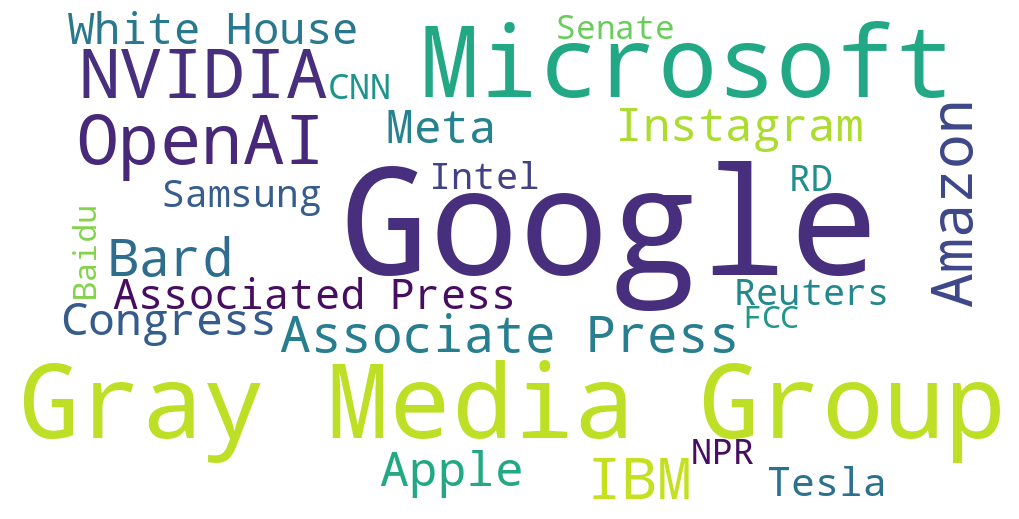

In [56]:
# Wordcloud for ORG entities
word_counts = spacy_org_top_clean.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [57]:
# Save this df for future use
spacy_org_clean.to_csv('spacy_ner_org.csv',index=False)

##### PERSON

In [27]:
spacy_person = spacy_ner_news_df[spacy_ner_news_df['Labels'] == 'PERSON']
spacy_person = spacy_person.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_person_top = spacy_person.head(50)
spacy_person_top

,Entities,Labels
0,Biden,12223
1,Elon Musk,10079
2,Musk,8729
3,Trump,8605
4,Sam Altman,8342
5,Joe Biden,5363
6,Altman,4911
7,Bing,4456
8,AI,4008
9,Donald Trump,3763


In [28]:
# Dictionary for combining related entities
combine_person_entities = {
    'Biden': 'Joe Biden',
    'Bidens': 'Joe Biden',
    'Joe Bidens' : 'Joe Biden',
    'Musk': 'Elon Musk',
    'Trump': 'Donald Trump',
    'Altman': 'Sam Altman',
    'Bidens': 'Joe Biden',
    'Trumps': 'Donald Trump',
    'Pichai': 'Sundar Pichai',
    'Hinton': 'Geoffrey Hinton',
    'Schumer': 'Chuck Schumer',
    'DeSantis' : 'Ron DeSantis',
    'McCartney' : 'Paul McCartney',
    'Putin' : 'Vladimir Putin',
    'Zuckerberg' : 'Mark Zuckerberg'
}

# List of entities that are not people or irrelevant
unwanted_entities = {
    'Bing', 'AI', 'DescriptionAt Gray', 'Bard', 'WFMZTV MeTV', 'ChatGPT',
    'Jones', 'Nvidias', 'WUNC', 'Ernie Bot', 'PolicyDo Sell InfoHelp',
    'AdvertisingAt Gray', 'Ai Weiwei', 'StatementFCC DescriptionAt Gray', 'Su Tierra Tiempo',
    'AdviceFamily RentLabor', 'Jim Thorpe', 'HISPANIC', 'Deep', 'RSIStochastic STCVolatility VOLAVolume VOLVolume',
    'Yen JPYGreat', 'SARSCoV' , 'GBPSwiss Franc CHFNew', 'Shakespeare', 'StatementFCC AdvertisingAt Gray', 'Costello',
    'inperson', 'bewerten', 'kostenlose von', 'Wertpapiere zu verstehen Wir empfehlen Interessenten und potenziellen Anlegern den Basisprospekt',
    'Risiken', 'erwerben das nicht einfach ist','Instagram' , 'Vectorspace AI'
}

spacy_person_clean = spacy_person[~spacy_person['Entities'].isin(unwanted_entities)]
spacy_person_clean['Entities'] = spacy_person_clean['Entities'].replace(combine_person_entities)
spacy_person_clean = spacy_person_clean.groupby('Entities', as_index=False)['Labels'].sum()
spacy_person_clean = spacy_person_clean.sort_values(by='Labels', ascending=False)

# Get the top entities after cleaning
spacy_person_top_clean = spacy_person_clean.reset_index().head(25)
spacy_person_top_clean

,index,Entities,Labels
0,203406,Joe Biden,20910
1,127221,Elon Musk,18808
2,116722,Donald Trump,14501
3,368021,Sam Altman,13253
4,402134,Sundar Pichai,4599
5,268549,Mark Zuckerberg,4077
6,152727,Geoffrey Hinton,4022
7,84156,Chuck Schumer,4010
8,437229,Vladimir Putin,3342
9,85693,Claude,2532


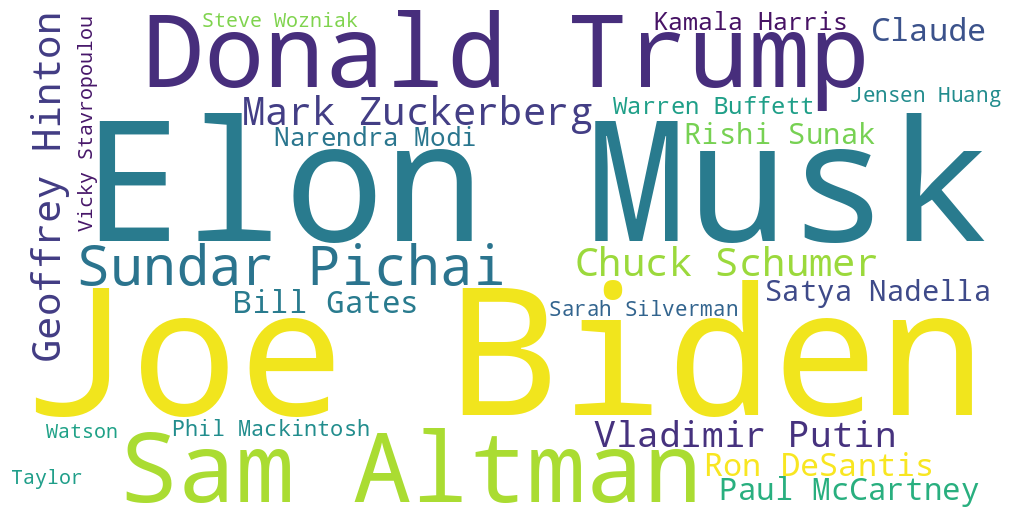

In [73]:
# Wordcloud for PERSON entities
word_counts = spacy_person_top_clean.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [29]:
# Save this df for future use
spacy_person_clean.to_csv('spacy_ner_person.csv',index=False)

##### GPE

In [30]:
spacy_gpe = spacy_ner_news_df[spacy_ner_news_df['Labels'] == 'GPE']
spacy_gpe = spacy_gpe.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_gpe_top = spacy_gpe.head(50)
spacy_gpe_top

,Entities,Labels
0,India,66655
1,China,50946
2,PRNewswire,50187
3,Japan,26093
4,Russia,22507
5,Texas,22416
6,France,22281
7,Germany,19771
8,Canada,19321
9,California,18879


In [31]:
unwanted_entities = {'PRNewswire'}

spacy_gpe_clean = spacy_gpe[~spacy_gpe['Entities'].isin(unwanted_entities)]
spacy_gpe_clean = spacy_gpe_clean.groupby('Entities', as_index=False)['Labels'].sum()
spacy_gpe_clean = spacy_gpe_clean.sort_values(by='Labels', ascending=False)

# Get the top entities after cleaning
spacy_gpe_top_clean = spacy_gpe_clean.reset_index().head(25)
spacy_gpe_top_clean

,index,Entities,Labels
0,16211,India,66655
1,6722,China,50946
2,17090,Japan,26093
3,33942,Russia,22507
4,40681,Texas,22416
5,12173,France,22281
6,12856,Germany,19771
7,5914,Canada,19321
8,5787,California,18879
9,44416,Washington,16513


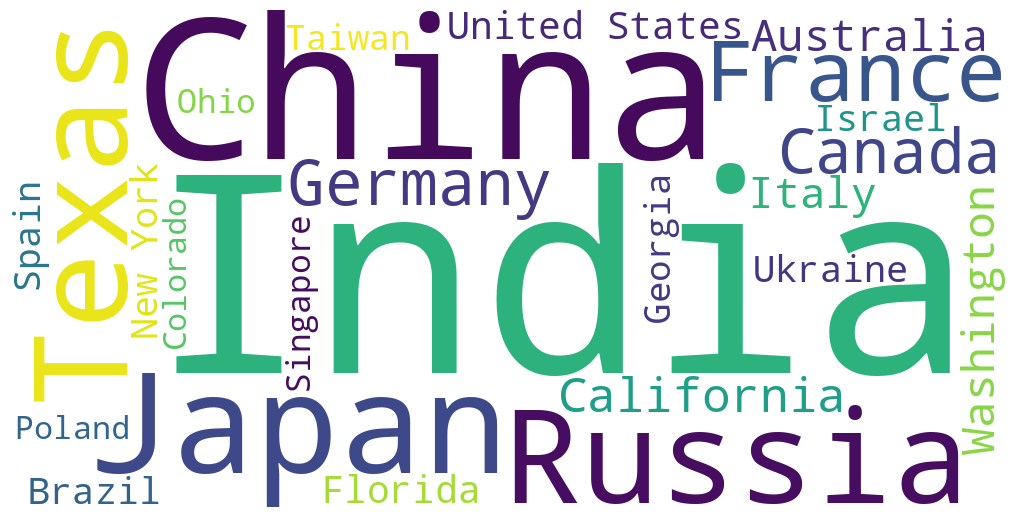

In [77]:
# Wordcloud for GPE entities
word_counts = spacy_gpe_top_clean.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [32]:
# Save this df for future use
spacy_gpe_clean.to_csv('spacy_ner_gpe.csv',index=False)

##### LOC

In [67]:
spacy_loc = spacy_ner_news_df[spacy_ner_news_df['Labels'] == 'LOC']
spacy_loc = spacy_loc.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_loc.head(50)

,Entities,Labels
0,Europe,11195
1,North America,6311
2,Silicon Valley,4247
3,North America Europe,3931
4,Earth,3099
5,Middle East Africa,2909
6,Asia,2889
7,Africa,2525
8,Americas,2105
9,Middle East,2085


In [73]:
# Define mappings for locations that need to be combined
location_combine_entities = {
    'Silicon Valleys': 'Silicon Valley',
    'North Americas': 'North America',
    'North America Europe Asia Pacific': 'North America Europe Asia',
    'San Francisco Bay Area': 'Bay Area',
    'Americas Europe': 'Americas',
    'Europe Asia': 'Europe',
    'Asia East Asia South Asia': 'Asia',
    'Latin America Middle East Africa': 'Latin America Middle East',
}

# List of entries that are not actual locations or not relevant
location_unwanted_entities = {
    'New AI', 'Xrays', 'Flapmax'
}

spacy_loc_clean = (
    spacy_loc[~spacy_loc['Entities'].isin(location_unwanted_entities)]
    .replace({'Entities': location_combine_entities})
    .groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_loc_top_clean = spacy_loc_clean.reset_index().head(20)
spacy_loc_top_clean

,index,Entities,Labels
0,5531,Europe,11404
1,12248,North America,6663
2,16286,Silicon Valley,5326
3,12340,North America Europe,3931
4,1215,Asia,3250
5,4640,Earth,3099
6,10502,Middle East Africa,2909
7,599,Africa,2525
8,880,Americas,2326
9,10500,Middle East,2085


In [74]:
# Save this df for future use
# spacy_loc.to_csv('spacy_ner_loc_1.csv',index=False)

##### PRODUCT

In [91]:
spacy_product = spacy_ner_news_df[spacy_ner_news_df['Labels'] == 'PRODUCT']
spacy_product = spacy_product.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_product_top = spacy_product.head(60)
spacy_product_top

,Entities,Labels
0,AI,563754
1,AIdriven,10744
2,Bing,5687
3,Get Android,5429
4,YouTube,5138
5,Opens,4784
6,Google Cloud,4128
7,Windows,3699
8,AI AI,3211
9,JavaScript,2628


In [92]:
# Mapping for product entities to be combined
product_combine_entities = {
    'Get Android': 'Android',
    'Air Stations Air': 'Air Stations',
    'Air Stations Air Playing': 'Air Stations',
    'Pixel Pro': 'Pixel',
    'Google Play Weather App Get iOS Weather app Get Android Weather': 'Weather Apps',
    'BTCEthereum AdaRipple': 'Cryptocurrency',
    'AUDCrypto FocusBitcoin': 'Cryptocurrency',
    'ToolsPivot Point Statistic TermsForex Retirement Industry': 'Financial Tools',
    'NewsMarket NewsForex': 'Financial News',
    'Smart Portfolio': 'Financial Tools',
    'TipRanks Go Smart Portfolio Back Add': 'Financial Tools',
    'Reddit VKontakte': 'Social Media Platforms',
    # Add more mappings as required
}

# List of non-product or irrelevant entries
product_unwanted_entities = {
    'AI AI', 'AIdriven', 'Open AI', 'AI ML', 'F', 'AI', 'ML', 'DeepMind', 'SpaceX',
    'Opens', 'HelpSupport', 'Logout', 'CES', 'EV', 'Discovery', 'FameGolden Kitty Awards', 
    'Columbia', 'Newsource', 'ADAS', 'Key', 'Pro', 'Core', 'Logout', 'Get Android'
}

# Apply normalization and cleaning to the PRODUCT entities
spacy_product_clean = (
    spacy_product[~spacy_product['Entities'].isin(product_unwanted_entities)]
    .replace({'Entities': product_combine_entities})
    .groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_product_top_clean = spacy_product_clean.reset_index().head(25)
spacy_product_top_clean

,index,Entities,Labels
0,20786,Bing,5687
1,111246,YouTube,5138
2,51607,Google Cloud,4128
3,45050,Financial Tools,3791
4,107597,Windows,3699
5,14234,Air Stations,3613
6,78406,Pixel,2833
7,58439,JavaScript,2628
8,24341,CRM,2583
9,34882,Cryptocurrency,2472


In [93]:
# Manually reclassify 'ChatGPT' and 'Bard' as 'PRODUCT' and sum their counts
additional_products = {
    'ChatGPT': spacy_ner_news_df_group[spacy_ner_news_df_group['Entities'] == 'ChatGPT']['count'].sum(),
    'GPT': spacy_ner_news_df_group[spacy_ner_news_df_group['Entities'] == 'GPT']['count'].sum(),
    'Bard': spacy_ner_news_df_group[spacy_ner_news_df_group['Entities'] == 'Bard']['count'].sum()
}

additional_products_df = pd.DataFrame(list(additional_products.items()), columns=['Entities', 'Labels'])

# Concatenate the additional products DataFrame with the spacy_product_clean DataFrame
spacy_product_clean = pd.concat([spacy_product_clean, additional_products_df], ignore_index=True)

# Regroup to combine the counts for any entities that are the same
spacy_product_clean = (
    spacy_product_clean.groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_product_top_clean = spacy_product_clean.head(25)
spacy_product_top_clean

,Entities,Labels
26802,ChatGPT,146168
47354,GPT,34779
19932,Bard,17830
20786,Bing,5687
111246,YouTube,5138
51607,Google Cloud,4128
45050,Financial Tools,3791
107597,Windows,3699
14234,Air Stations,3613
78406,Pixel,2833


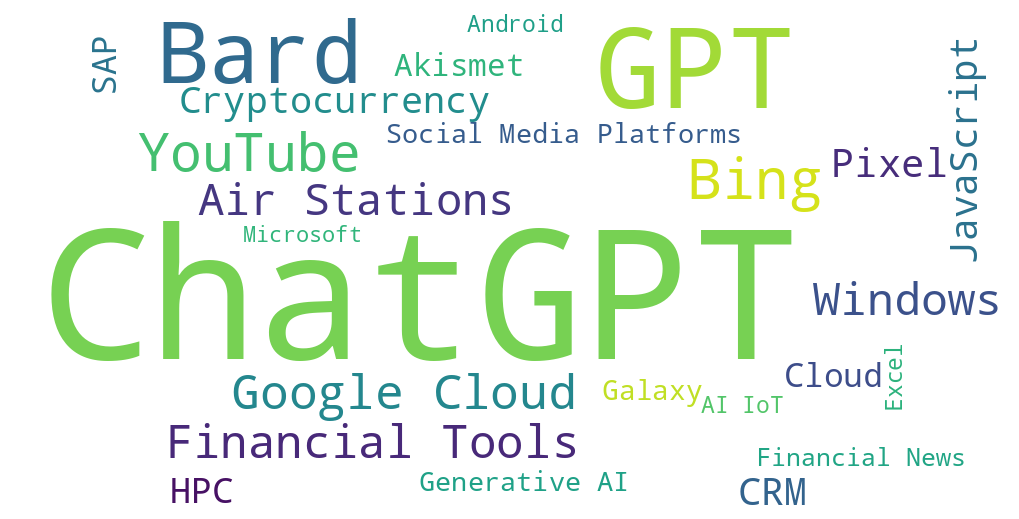

In [96]:
# Wordcloud for PRODUCT entities
word_counts = spacy_product_top_clean.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [95]:
# Save this df for future use
spacy_product_clean.to_csv('spacy_ner_product.csv',index=False)

##### spaCy Medium Model with NER

In [79]:
# Load spaCy model
nlp = spacy.load("en_core_web_md", enable=['ner'])
nlp.add_pipe('merge_entities')

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)


============================= Pipeline Overview =============================

#   Component        Assigns          Requires         Scores          Retokenizes
-   --------------   --------------   --------------   -------------   -----------
0   ner              doc.ents                          ents_f          False      
                     token.ent_iob                     ents_p                     
                     token.ent_type                    ents_r                     
                                                       ents_per_type              
                                                                                  
1   merge_entities                    doc.ents                         True       
                                      token.ent_iob                               
                                      token.ent_type                              

✔ No problems found.
{'summary': {'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token

In [80]:
# news_text = news_df['cleaned_text'].str.cat(sep=' ')

In [81]:
%%time

# Define a batch size
batch_size = 100000

entities = []
labels = []

# Split the long text into batches
text_batches = [news_text[i:i + batch_size] for i in range(0, len(news_text), batch_size)]

# Process each batch with spaCy
for text in tqdm(text_batches):
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
    
entities_labels2 = list(zip(entities, labels))
spacy_md_news_df = pd.DataFrame({'Entities': entities,'Labels': labels})

100%|██████████| 10410/10410 [1:46:04<00:00,  1.64it/s] 


CPU times: user 1h 46min 6s, sys: 11.6 s, total: 1h 46min 18s
Wall time: 1h 46min 9s


In [82]:
spacy_md_news_df

,Entities,Labels
0,LegalTech,ORG
1,Australis Galus,PERSON
2,Australis,GPE
3,Wednesday,DATE
4,February,DATE
...,...,...
13584394,Josh DursoHe,PERSON
13584395,Finger Lakes Times,ORG
13584396,Eiramorg,ORG
13584397,InFocusco,PERSON


In [85]:
spacy_md_news_df.Labels.value_counts()

Labels
ORG            5868559
PERSON         2297265
GPE            1995370
DATE           1173567
PRODUCT         519272
CARDINAL        513582
NORP            353967
TIME            177049
ORDINAL         171426
WORK_OF_ART     161600
LOC             145715
EVENT            63640
FAC              58876
MONEY            32769
LAW              28428
LANGUAGE         14368
QUANTITY          6406
PERCENT           2540
Name: count, dtype: int64

In [35]:
# Save this df for future use
spacy_md_news_df.to_csv('spacy_medium_news_text_df.csv',index=False)

In [86]:
spacy_md_news_df_group = spacy_md_news_df.groupby(['Entities', 'Labels']).size().reset_index().rename(columns={0:'count'}).sort_values('count',ascending=False).reset_index()
spacy_md_news_df_group.head(20)

,index,Entities,Labels,count
0,5676,AI,ORG,275821
1,1988939,one,CARDINAL,115934
2,1928159,first,ORDINAL,113833
3,727246,Gray Media Group,ORG,77933
4,2023085,today,DATE,68243
5,711907,Google,ORG,61395
6,826451,India,GPE,53101
7,2025584,two,CARDINAL,53057
8,359436,China,GPE,52566
9,1124421,Microsoft,ORG,52531


#### Entity Identification Over Time

In [18]:
# Load spaCy model
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser"])
nlp.add_pipe('merge_entities')
nlp.enable_pipe("ner")

analysis = nlp.analyze_pipes(pretty=True)
print(analysis)


============================= Pipeline Overview =============================

#   Component         Assigns          Requires         Scores          Retokenizes
-   ---------------   --------------   --------------   -------------   -----------
0   tok2vec           doc.tensor                                        False      
                                                                                   
1   attribute_ruler                                                     False      
                                                                                   
2   lemmatizer        token.lemma                       lemma_acc       False      
                                                                                   
3   ner               doc.ents                          ents_f          False      
                      token.ent_iob                     ents_p                     
                      token.ent_type                    ents_r                  

In [19]:
%%time

entities = []
labels = []
indices = []

# Process each article with spaCy
for index, row in tqdm(news_df.iterrows(), total=news_df.shape[0]):
    doc = nlp(row['cleaned_text'])
    for ent in doc.ents:
        entities.append(ent.text)
        labels.append(ent.label_)
        indices.append(index)

# Create a DataFrame for the entities
spacy_ner_news_df2 = pd.DataFrame({'index': indices, 'Entities': entities, 'Labels': labels})

  0%|          | 0/183609 [00:00<?, ?it/s]

CPU times: user 3h 16min 57s, sys: 36.7 s, total: 3h 17min 34s
Wall time: 3h 16min 40s


In [20]:
spacy_ner_news_df2

,index,Entities,Labels
0,0,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,0,Wednesday February,DATE
2,0,Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights,EVENT
3,0,Sony,ORG
4,0,Aristocrat,NORP
...,...,...,...
14345385,183608,Infersecom,PERSON
14345386,183608,Finger Lakes Times,ORG
14345387,183608,Eiramorg,ORG
14345388,183608,InFocusco,NORP


In [21]:
spacy_ner_news_df2.Labels.value_counts()

Labels
ORG            5974426
PERSON         2163685
GPE            2068008
PRODUCT        1173709
DATE           1065637
CARDINAL        513382
NORP            354076
TIME            231474
WORK_OF_ART     224599
ORDINAL         161977
LOC             134750
FAC             105574
EVENT            84238
MONEY            36151
LAW              26837
LANGUAGE         17688
QUANTITY          6241
PERCENT           2938
Name: count, dtype: int64

In [22]:
merged_spacy_df = pd.merge(news_df[['index', 'year-month']], spacy_ner_news_df2, on='index')

In [44]:
print(merged_spacy_df.shape)
merged_spacy_df.head(10)

(13758828, 4)


,index,year-month,Entities,Labels
0,0,2020-02,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,0,2020-02,Wednesday February,DATE
2,0,2020-02,Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights,EVENT
3,0,2020-02,Sony,ORG
4,0,2020-02,Aristocrat,NORP
5,0,2020-02,Leisure IGT Infectious Disease Testing Using PCR IVD Market Comprehensive Study Companies Thermo Fisher BD Roche Diagnostics Veterinary Dental Xray Generators Market Comprehensive Study Companies,ORG
6,0,2020-02,Planmeca Midmark,PERSON
7,0,2020-02,Optotechnik Gowllands,PERSON
8,0,2020-02,NewsLegalTech,PERSON
9,0,2020-02,tanmay February,ORG


In [52]:
merged_spacy_df.columns

Index(['index', 'year-month', 'Entities', 'Labels'], dtype='object')

In [29]:
# Group by date and Labels to get the count of each entity type over time
entity_time_series = merged_spacy_df.groupby(['year-month', 'Labels']).size().unstack(fill_value=0)
entity_time_series.head()

Labels,CARDINAL,DATE,EVENT,FAC,GPE,LANGUAGE,LAW,LOC,MONEY,NORP,ORDINAL,ORG,PERCENT,PERSON,PRODUCT,QUANTITY,TIME,WORK_OF_ART
year-month,,,,,,,,,,,,,,,,,,
2020-01,5146,10502,756,934,20251,165,285,1362,326,3179,1549,56798,27,20609,10721,63,2120,2177
2020-02,4489,9377,772,889,18253,140,243,1122,329,3274,1421,53191,36,19793,10313,45,2175,2004
2020-03,4860,10381,738,1105,21195,197,242,1255,296,3604,1523,59836,29,21275,11868,69,2292,2127
2020-04,4961,9923,788,1056,18653,199,257,1302,333,3138,1477,57066,26,19894,11408,58,1933,2242
2020-05,4397,9996,820,1062,18402,193,228,1250,321,3277,1448,53039,22,20245,10180,66,1931,2059


In [43]:
# Save this df for future use
merged_spacy_df.to_csv('spacy_news_time_df.csv',index=False)

bucket_name = 'minhvo-nlp'
file_path = 'spacy_news_time_df.csv'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)

In [14]:
# Reload data
merged_spacy_df = pd.read_csv('spacy_news_time_df.csv')
print(merged_spacy_df.shape)
merged_spacy_df.head()

(13758828, 4)


,index,year-month,Entities,Labels
0,0,2020-02,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,0,2020-02,Wednesday February,DATE
2,0,2020-02,Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights,EVENT
3,0,2020-02,Sony,ORG
4,0,2020-02,Aristocrat,NORP


In [33]:
spacy_news_time_group = merged_spacy_df.groupby(['Entities', 'Labels', 'year-month']).size().reset_index().rename(columns={0:'count'}).sort_values('count',ascending=False).reset_index()
spacy_news_time_group.head(20)

,index,Entities,Labels,year-month,count
0,13052,AI,PRODUCT,2023-09,39599
1,13048,AI,PRODUCT,2023-05,39040
2,13051,AI,PRODUCT,2023-08,38988
3,13049,AI,PRODUCT,2023-06,37172
4,13050,AI,PRODUCT,2023-07,31737
5,13047,AI,PRODUCT,2023-04,27656
6,13046,AI,PRODUCT,2023-03,27643
7,13045,AI,PRODUCT,2023-02,24753
8,12959,AI,ORG,2023-08,19635
9,12960,AI,ORG,2023-09,19584


##### ORG

In [42]:
spacy_org2 = merged_spacy_df[merged_spacy_df['Labels'] == 'ORG']
spacy_org2 = spacy_org2.groupby('Entities', as_index=False).count().sort_values(by = "Labels", ascending = False)
spacy_org_top2 = spacy_org2.head(40)
spacy_org_top2

,Entities,index,year-month,Labels
3987,AI,262491,262491,262491
199699,ChatGPT,138494,138494,138494
405525,Gray Media Group,72134,72134,72134
396156,Google,71208,71208,71208
581449,Microsoft,55430,55430,55430
362449,GPT,31772,31772,31772
664911,OpenAI,26916,26916,26916
64296,Amazon,18260,18260,18260
442062,IBM,18103,18103,18103
1012985,intelligenceA Gray Media Group Inc Station Gray Television Inc,17018,17018,17018


In [16]:
# Create a dictionary for entities that need to be combined
combine_entities = {
    'Googles': 'Google',
    'Microsofts': 'Microsoft',
    'Nvidia': 'NVIDIA',
    'AP': 'Associated Press',
    'Gray Media Group Inc Station Gray Television Inc': 'Gray Media Group'
}

# Remove any unwanted entities
unwanted_entities = {'AIgenerated', 'EU', 'datadriven', 'AI', 'ML', 'Artificial Intelligence', 'ChatGPT', 'GPT', 'DALLE',
                     'intelligenceA Gray Media Group Inc Station Gray Television Inc'}

# Clean the DataFrame
spacy_org_clean2 = (
    spacy_org2[~spacy_org2['Entities'].isin(unwanted_entities)]
    .replace({'Entities': combine_entities})
    .groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

# Get the top entities after cleaning
spacy_org_top_clean2 = spacy_org_clean2.reset_index().head(25)
spacy_org_top_clean2

,index,Entities,Labels
0,396148,Google,84141
1,405516,Gray Media Group,80694
2,581438,Microsoft,66328
3,664896,OpenAI,26916
4,615985,NVIDIA,26350
5,99573,Associated Press,23463
6,64293,Amazon,18260
7,442052,IBM,18103
8,124606,Bard,14336
9,76333,Apple,12437


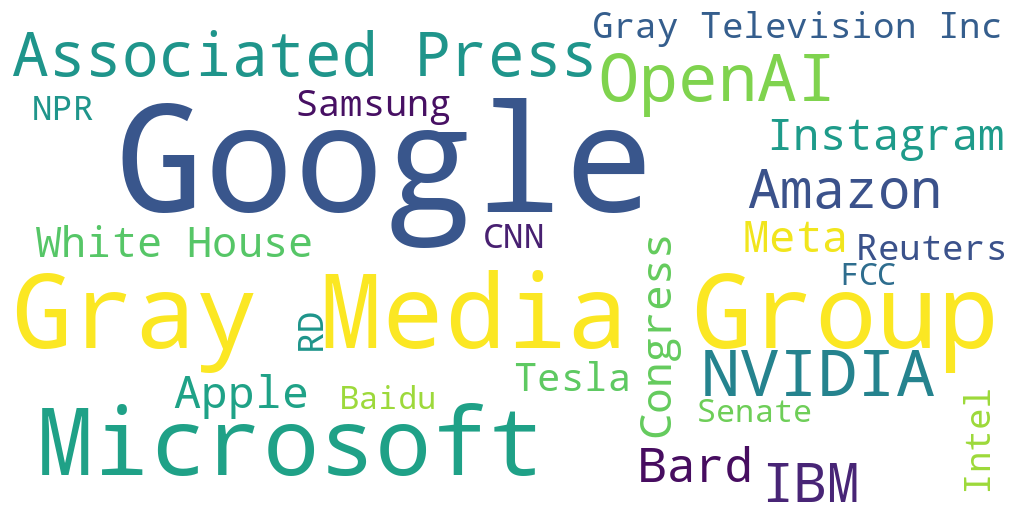

In [58]:
# Wordcloud for ORG entities
word_counts = spacy_org_top_clean2.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

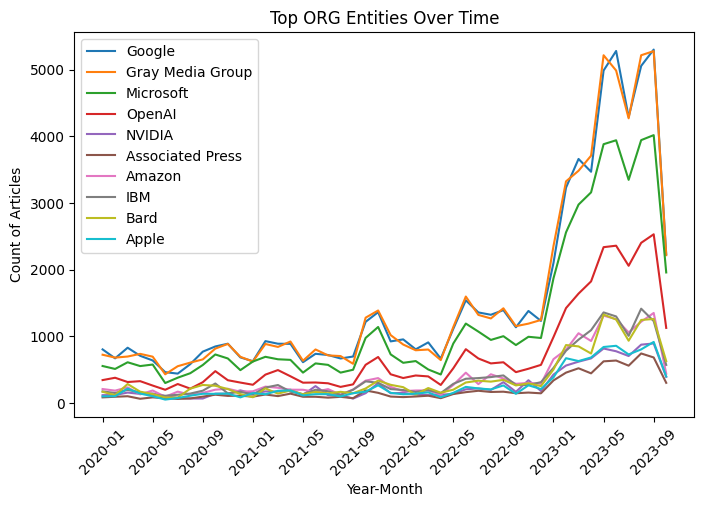

In [38]:
# Step 1: Identify the top 10 ORG entities
top_org_entities = spacy_org_top_clean2['Entities'].head(10).tolist()

# Step 2: Filter `merged_spacy_df` for each of the top entities and calculate counts over time
top_org_time_series = {}

for entity in top_org_entities:
    is_top_entity = merged_spacy_df['Entities'] == entity
    entity_time_series = merged_spacy_df[is_top_entity].groupby('year-month').size()
    top_org_time_series[entity] = entity_time_series

# Step 3: Merge into a single DataFrame
top_org_df = pd.DataFrame(top_org_time_series).fillna(0).reset_index()

plt.figure(figsize=(8,5))
for entity in top_org_entities:
    plt.plot(top_org_df['year-month'], top_org_df[entity], label=entity)

plt.xlabel('Year-Month')
plt.ylabel('Count of Articles')
plt.title('Top ORG Entities Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

In [99]:
# Save this df for future use
spacy_org2.to_csv('spacy_org_time.csv',index=False)

##### PERSON

In [20]:
spacy_person2 = merged_spacy_df[merged_spacy_df['Labels'] == 'PERSON']
spacy_person2 = spacy_person2.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_person_top2 = spacy_person2.head(50)
spacy_person_top2

,Entities,index,year-month,Labels
0,Biden,11972,11972,11972
1,Elon Musk,9914,9914,9914
2,Musk,8483,8483,8483
3,Trump,8261,8261,8261
4,Sam Altman,8040,8040,8040
5,Joe Biden,5133,5133,5133
6,Altman,4749,4749,4749
7,Bing,4282,4282,4282
8,AI,3893,3893,3893
9,Donald Trump,3627,3627,3627


In [21]:
# Dictionary for combining related entities
combine_person_entities = {
    'Biden': 'Joe Biden',
    'Bidens': 'Joe Biden',
    'Joe Bidens' : 'Joe Biden',
    'Musk': 'Elon Musk',
    'Trump': 'Donald Trump',
    'Altman': 'Sam Altman',
    'Bidens': 'Joe Biden',
    'Trumps': 'Donald Trump',
    'Pichai': 'Sundar Pichai',
    'Hinton': 'Geoffrey Hinton',
    'Schumer': 'Chuck Schumer',
    'DeSantis' : 'Ron DeSantis',
    'McCartney' : 'Paul McCartney',
    'Putin' : 'Vladimir Putin',
    'Zuckerberg' : 'Mark Zuckerberg',
    'Sunak' : 'Rishi Sunak'
}

# List of entities that are not people or irrelevant
unwanted_entities = {
    'Bing', 'AI', 'DescriptionAt Gray', 'Bard', 'WFMZTV MeTV', 'ChatGPT',
    'Jones', 'Nvidias', 'WUNC', 'Ernie Bot', 'PolicyDo Sell InfoHelp',
    'AdvertisingAt Gray', 'Ai Weiwei', 'StatementFCC DescriptionAt Gray', 'Su Tierra Tiempo',
    'AdviceFamily RentLabor', 'Jim Thorpe', 'HISPANIC', 'Deep', 'RSIStochastic STCVolatility VOLAVolume VOLVolume',
    'Yen JPYGreat', 'SARSCoV' , 'GBPSwiss Franc CHFNew', 'Shakespeare', 'StatementFCC AdvertisingAt Gray', 'Costello',
    'inperson', 'bewerten', 'kostenlose von', 'Wertpapiere zu verstehen Wir empfehlen Interessenten und potenziellen Anlegern den Basisprospekt',
    'Risiken', 'erwerben das nicht einfach ist','Instagram' , 'Vectorspace AI' ,'verstehen sein kann von AGB Disclaimer'
}

spacy_person_clean2 = spacy_person2[~spacy_person2['Entities'].isin(unwanted_entities)]
spacy_person_clean2['Entities'] = spacy_person_clean2['Entities'].replace(combine_person_entities)
spacy_person_clean2 = spacy_person_clean2.groupby('Entities', as_index=False)['Labels'].sum()
spacy_person_clean2 = spacy_person_clean2.sort_values(by='Labels', ascending=False)

# Get the top entities after cleaning
spacy_person_top_clean2 = spacy_person_clean2.reset_index().head(25)
spacy_person_top_clean2

,index,Entities,Labels
0,196575,Joe Biden,20330
1,123123,Elon Musk,18397
2,112961,Donald Trump,13930
3,355951,Sam Altman,12789
4,388968,Sundar Pichai,4463
5,259717,Mark Zuckerberg,3965
6,81505,Chuck Schumer,3885
7,147607,Geoffrey Hinton,3835
8,422865,Vladimir Putin,3172
9,341996,Rishi Sunak,2929


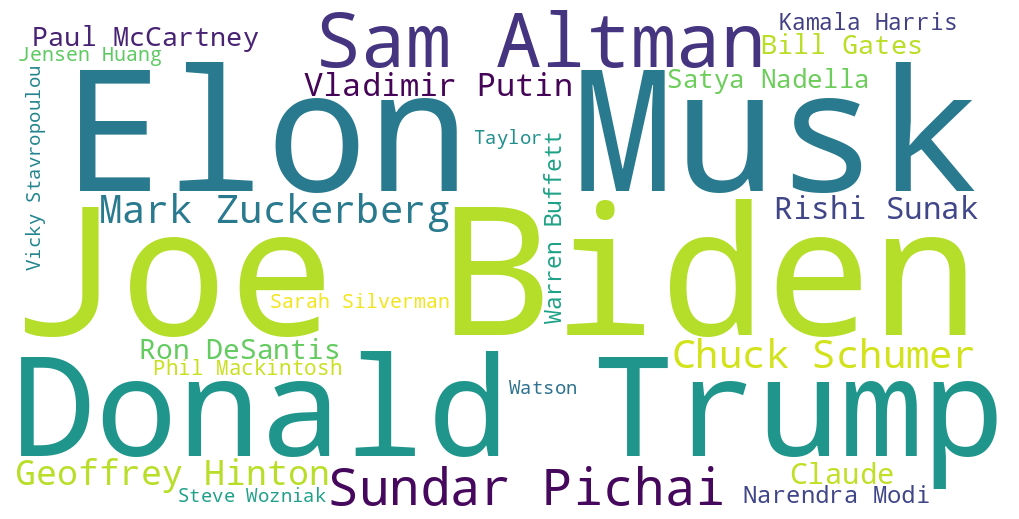

In [69]:
# Wordcloud for PERSON entities
word_counts = spacy_person_top_clean2.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

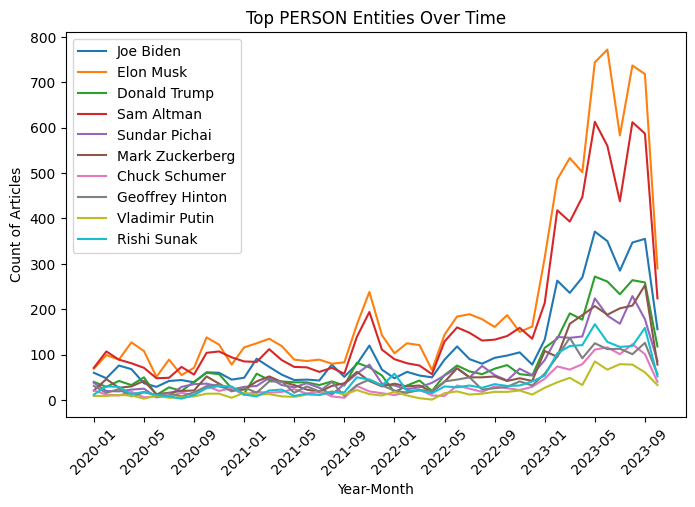

In [23]:
top_person_entities = spacy_person_top_clean2['Entities'].head(10).tolist()
top_person_time_series = {}

for entity in top_person_entities:
    is_top_entity = merged_spacy_df['Entities'] == entity
    entity_time_series = merged_spacy_df[is_top_entity].groupby('year-month').size()
    top_person_time_series[entity] = entity_time_series

top_person_df = pd.DataFrame(top_person_time_series).fillna(0).reset_index()

plt.figure(figsize=(8,5))
for entity in top_person_entities:
    plt.plot(top_person_df['year-month'], top_person_df[entity], label=entity)

plt.xlabel('Year-Month')
plt.ylabel('Count of Articles')
plt.title('Top PERSON Entities Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

In [100]:
# Save this df for future use
spacy_person2.to_csv('spacy_person_time.csv',index=False)

##### GPE

In [24]:
spacy_gpe2 = merged_spacy_df[merged_spacy_df['Labels'] == 'GPE']
spacy_gpe2 = spacy_gpe2.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_gpe_top2 = spacy_gpe2.head(50)
spacy_gpe_top2

,Entities,index,year-month,Labels
0,India,64021,64021,64021
1,China,48942,48942,48942
2,PRNewswire,48165,48165,48165
3,Japan,25024,25024,25024
4,Russia,21604,21604,21604
5,Texas,21547,21547,21547
6,France,21350,21350,21350
7,Germany,18964,18964,18964
8,Canada,18537,18537,18537
9,California,18060,18060,18060


In [27]:
unwanted_entities = {'PRNewswire'}
# combine_gpe_entities = {
#     'Texas': 'United States',
#     'California': 'United States',
#     'Washington': 'United States',
#     'Florida' : 'United States',
#     'New York' : 'United States',
#     'Georgia': 'United States',
#     'Ohio': 'United States',
#     'Colorado': 'United States',
#     'Michigan': 'United States',
#     'San Francisco': 'United States',
#     'Pennsylvania': 'United States',
#     'Alabama': 'United States',
#     'Connecticut': 'United States',
#     'Iowa' : 'United States',
#     'Dakota' : 'United States',
#     'Massachusetts' : 'United States',
#     'Arizona' : 'United States',
#     'Illinois' : 'United States'
# }

spacy_gpe_clean2 = spacy_gpe2[~spacy_gpe2['Entities'].isin(unwanted_entities)]
# spacy_gpe_clean2['Entities'] = spacy_gpe_clean2['Entities'].replace(combine_gpe_entities)
spacy_gpe_clean2 = spacy_gpe_clean2.groupby('Entities', as_index=False)['Labels'].sum()
spacy_gpe_clean2 = spacy_gpe_clean2.sort_values(by='Labels', ascending=False)

# Get the top entities after cleaning
spacy_gpe_top_clean2 = spacy_gpe_clean2.reset_index().head(25)
spacy_gpe_top_clean2

,index,Entities,Labels
0,15742,India,64021
1,6539,China,48942
2,16597,Japan,25024
3,32980,Russia,21604
4,39556,Texas,21547
5,11814,France,21350
6,12475,Germany,18964
7,5751,Canada,18537
8,5629,California,18060
9,43173,Washington,15828


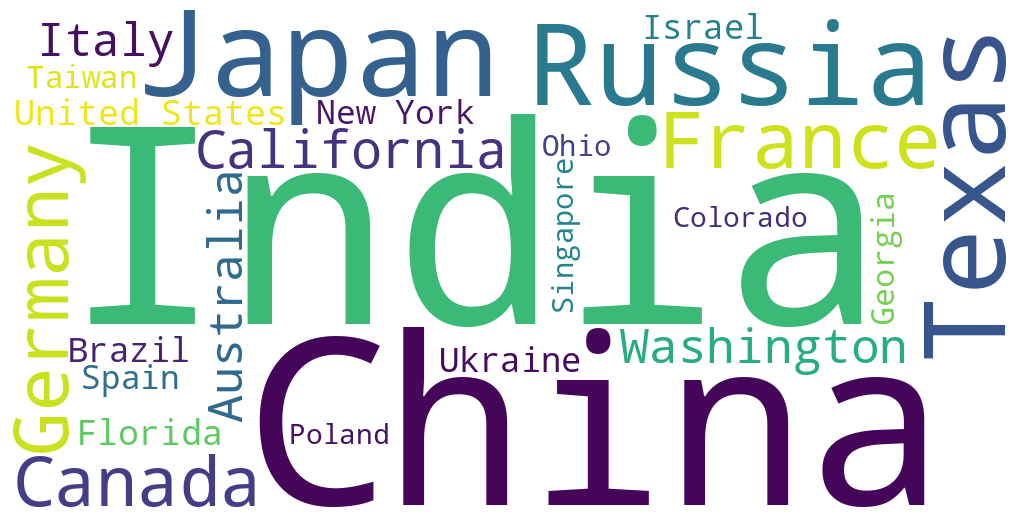

In [29]:
# Wordcloud for GPE entities
word_counts = spacy_gpe_top_clean2.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

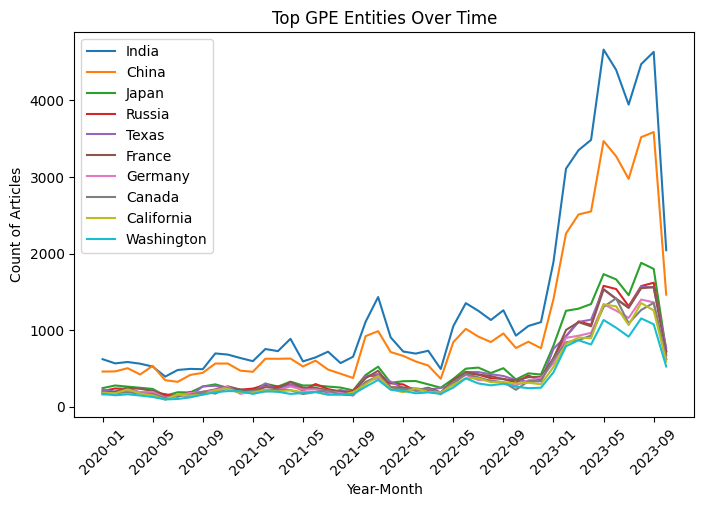

In [28]:
top_gpe_entities = spacy_gpe_top_clean2['Entities'].head(10).tolist()
top_gpe_time_series = {}

for entity in top_gpe_entities:
    is_top_entity = merged_spacy_df['Entities'] == entity
    entity_time_series = merged_spacy_df[is_top_entity].groupby('year-month').size()
    top_gpe_time_series[entity] = entity_time_series

top_gpe_df = pd.DataFrame(top_gpe_time_series).fillna(0).reset_index()

plt.figure(figsize=(8,5))
for entity in top_gpe_entities:
    plt.plot(top_gpe_df['year-month'], top_gpe_df[entity], label=entity)

plt.xlabel('Year-Month')
plt.ylabel('Count of Articles')
plt.title('Top GPE Entities Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

In [101]:
# Save this df for future use
spacy_gpe2.to_csv('spacy_gpe_time.csv',index=False)

##### PRODUCT

In [30]:
spacy_product2 = merged_spacy_df[merged_spacy_df['Labels'] == 'PRODUCT']
spacy_product2 = spacy_product2.groupby("Entities").count().sort_values(by = "Labels", ascending = False).reset_index()
spacy_product_top2 = spacy_product2.head(60)
spacy_product_top2

,Entities,index,year-month,Labels
0,AI,539753,539753,539753
1,AIdriven,10331,10331,10331
2,Bing,5418,5418,5418
3,Get Android,5233,5233,5233
4,YouTube,4920,4920,4920
5,Opens,4692,4692,4692
6,Google Cloud,3921,3921,3921
7,Windows,3530,3530,3530
8,AI AI,3093,3093,3093
9,JavaScript,2546,2546,2546


In [35]:
# Mapping for product entities to be combined
product_combine_entities = {
    'Get Android': 'Android',
    'Air Stations Air': 'Air Stations',
    'Air Stations Air Playing': 'Air Stations',
    'Pixel Pro': 'Pixel',
    'Google Play Weather App Get iOS Weather app Get Android Weather': 'Weather Apps',
    'BTCEthereum AdaRipple': 'Cryptocurrency',
    'AUDCrypto FocusBitcoin': 'Cryptocurrency',
    'ToolsPivot Point Statistic TermsForex Retirement Industry': 'Financial Tools',
    'NewsMarket NewsForex': 'Financial News',
    'Smart Portfolio': 'Financial Tools',
    'TipRanks Go Smart Portfolio Back Add': 'Financial Tools',
    'Reddit VKontakte': 'Social Media Platforms'
}

# List of non-product or irrelevant entries
product_unwanted_entities = {
    'AI AI', 'AIdriven', 'Open AI', 'AI ML', 'F', 'AI', 'ML', 'DeepMind', 'SpaceX',
    'Opens', 'HelpSupport', 'Logout', 'CES', 'EV', 'Discovery', 'FameGolden Kitty Awards', 
    'Columbia', 'Newsource', 'ADAS', 'Key', 'Pro', 'Core', 'Logout', 'Get Android'
}

# Apply normalization and cleaning to the PRODUCT entities
spacy_product_clean2 = (
    spacy_product2[~spacy_product2['Entities'].isin(product_unwanted_entities)]
    .replace({'Entities': product_combine_entities})
    .groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_product_top_clean2 = spacy_product_clean2.reset_index().head(25)
spacy_product_top_clean2

,index,Entities,Labels
0,19942,Bing,5418
1,105421,YouTube,4920
2,49053,Google Cloud,3921
3,42751,Financial Tools,3633
4,102118,Windows,3530
5,13588,Air Stations,3479
6,74523,Pixel,2681
7,55417,JavaScript,2546
8,23355,CRM,2470
9,33025,Cryptocurrency,2382


In [36]:
# Manually reclassify 'ChatGPT' and 'Bard' as 'PRODUCT' and sum their counts
additional_products = {
    'ChatGPT': spacy_news_time_group[spacy_news_time_group['Entities'] == 'ChatGPT']['count'].sum(),
    'GPT': spacy_news_time_group[spacy_news_time_group['Entities'] == 'GPT']['count'].sum(),
    'Bard': spacy_news_time_group[spacy_news_time_group['Entities'] == 'Bard']['count'].sum()
}

additional_products_df = pd.DataFrame(list(additional_products.items()), columns=['Entities', 'Labels'])

# Concatenate the additional products DataFrame with the spacy_product_clean DataFrame
spacy_product_clean2 = pd.concat([spacy_product_clean2, additional_products_df], ignore_index=True)

# Regroup to combine the counts for any entities that are the same
spacy_product_clean2 = (
    spacy_product_clean2.groupby('Entities', as_index=False)['Labels'].sum()
    .sort_values(by='Labels', ascending=False)
)

spacy_product_top_clean2 = spacy_product_clean2.head(25)
spacy_product_top_clean2

,Entities,Labels
25717,ChatGPT,140948
44997,GPT,33186
19114,Bard,17141
19942,Bing,5418
105421,YouTube,4920
49053,Google Cloud,3921
42751,Financial Tools,3633
102118,Windows,3530
13588,Air Stations,3479
74523,Pixel,2681


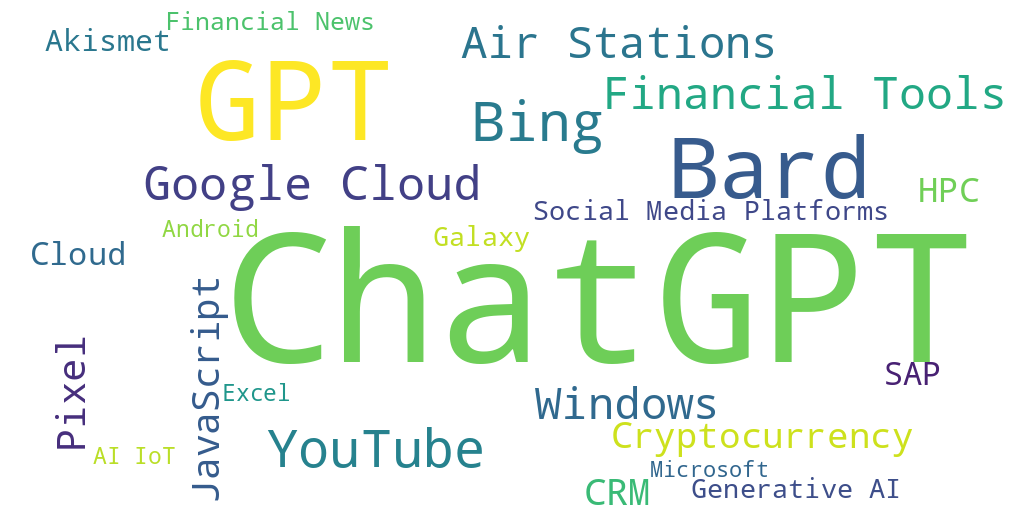

In [112]:
# Wordcloud for PRODUCT entities
word_counts = spacy_product_top_clean2.set_index('Entities')['Labels'].to_dict()

wordcloud_obj = wordcloud.WordCloud(
    width = 1000,
    height = 500,
    background_color = 'white',
    max_words=30,
    stopwords = wordcloud.STOPWORDS)

wordcloud_obj.generate_from_frequencies(word_counts)

fig = plt.figure(figsize = (10,5))
plt.imshow(wordcloud_obj, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

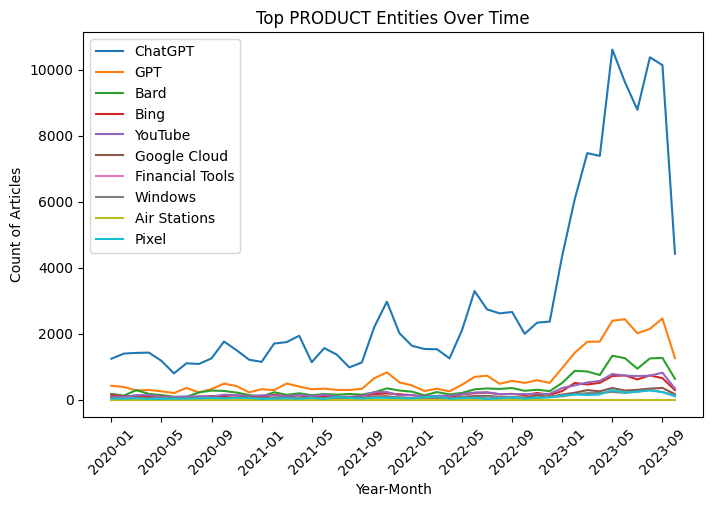

In [37]:
top_prod_entities = spacy_product_top_clean2['Entities'].head(10).tolist()
top_prod_time_series = {}

for entity in top_prod_entities:
    is_top_entity = merged_spacy_df['Entities'] == entity
    entity_time_series = merged_spacy_df[is_top_entity].groupby('year-month').size()
    top_prod_time_series[entity] = entity_time_series

top_prod_df = pd.DataFrame(top_prod_time_series).fillna(0).reset_index()

plt.figure(figsize=(8,5))
for entity in top_prod_entities:
    plt.plot(top_prod_df['year-month'], top_prod_df[entity], label=entity)

plt.xlabel('Year-Month')
plt.ylabel('Count of Articles')
plt.title('Top PRODUCT Entities Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15))
plt.show()

In [117]:
# Save this df for future use
spacy_product2.to_csv('spacy_product_time.csv',index=False)

#### Merge Entity Data with News Data

In [17]:
merged_spacy_df = pd.read_csv('spacy_news_time_df.csv')
print(merged_spacy_df.shape)
merged_spacy_df.head()

(13758828, 4)


,index,year-month,Entities,Labels
0,0,2020-02,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,0,2020-02,Wednesday February,DATE
2,0,2020-02,Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights,EVENT
3,0,2020-02,Sony,ORG
4,0,2020-02,Aristocrat,NORP


In [18]:
merged_df = pd.merge(news_df, merged_spacy_df[['index', 'Entities', 'Labels']], on='index')

print(merged_df.shape)
merged_df.head()

(13758828, 13)


,index,date,title,text,cleaned_title,cleaned_text,lemmatized_title,lemmatized_text,Sentiment,year-month,year,Entities,Labels
0,0,2020-02-26,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems eBREVIA Galus Australis Galus Australis Wednesday February Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights Apollo Games Sony Aristocrat Leisure IGT Infectious Dise...,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensive study company veterinary market comprehensive study company hein...,Negative,2020-02,2020,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems,ORG
1,0,2020-02-26,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal P...",legaltech artificial intelligence market technology advancement future scope casetext inc catalyst repository systems ebrevia galus australis,LegalTech Artificial Intelligence Market Technology Advancement Future Scope Casetext Inc Catalyst Repository Systems eBREVIA Galus Australis Galus Australis Wednesday February Trending Needle Counters Market Comprehensive Study Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook Business Insights Apollo Games Sony Aristocrat Leisure IGT Infectious Dise...,legaltech artificial intelligence market technology advancement catalyst repository system,legaltech artificial intelligence market technology advancement catalyst repository system galus trend needle counter market comprehensive study company industry market comprehensive study company industry global portable handheld electronic game machine market outlook business insight leisure infectious disease testing use market comprehensive study company roche diagnostic veterinary dental xray generator market comprehensi

In [ ]:
# Save this df
merged_df.to_parquet('entities_news_df.parquet')

bucket_name = 'minhvo-nlp'
file_path = 'entities_news_df.parquet'

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_path)
blob.upload_from_filename(file_path)